In [1]:
# preliminary installation 
# gensim is a Natural Language Processing (NLP) library

!pip install gensim

In [2]:
# Imports for libraries and modules 
# MAKE SURE TO RUN THIS FOR THE CODE TO WORK

import logging
import pandas as pd
import numpy as np
from numpy import random
import gensim
import nltk
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import re
from bs4 import BeautifulSoup

%matplotlib inline

In [4]:
# Read csv of pre-matched Titles to Tags

df = pd.read_csv('tweets.csv')
df = df[pd.notnull(df['Tags'])]
df.head(10)

,Tweets,Tags,Unnamed: 2
0,An inspiration in all aspects: Fashion,Delicious,NaN
1,go team,Delicious,NaN
2,literally beautiful just the way you are,Delicious,NaN
3,YASSSSS,Delicious,NaN
4,Beautiful album from the greatest unsung guit...,Delicious,NaN
5,Good luck to Rich riding for great project in ...,Delicious,NaN
6,Omg he... kissed... him crying with joy,Delicious,NaN
7,happy anniv ming and papi!!!!! love love happy,Delicious,NaN
8,music feeds my soul,Delicious,NaN
9,"dancing in my room , feeling happy",Delicious,NaN


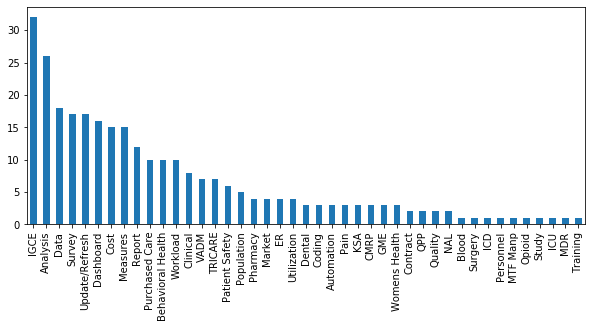

In [164]:
# Create a bar chart to analyze tags and see which tags are used the most
# my_tags is the list of tags we'll want to use to for the NLP model (further down)

my_tags = ['Analysis','Automation','Behavioral Health','Blood','Clinical','CMRP','Coding','Contract','Cost','Dashboard','Data','Dental','ER','GME','IGCE','KSA',
            'Market','Measures','N/A','NAL','Opioid','Pain','Patient Safety','Pharmacy','Population','Purchased Care','QPP','Quality','Report',
              'Survey','TRICARE','Update/Refresh','Utilization','VADM','Womens Health','Workload']
plt.figure(figsize=(10,4))
df.Tags.value_counts().plot(kind='bar');



In [165]:
# Create a function that match title and tag

def print_plot(index):
    example = df[df.index == index][['Title', 'Tags']].values[0]
    if len(example) > 0:
        print(example[0])
        print('Tag:', example[1])

In [166]:
# Print plot at the 10th index

print_plot(10)

201907311942_as 3965_ksa evaluation
Tag: KSA


In [167]:
# Print title and tag at the 138th index


print_plot(136)

201905061066_appointment analytics evaluation rep tricare dental program tdp transition
Tag: Dental


In [168]:
# make sure to use the stopwords

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\607223\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [169]:
#Clean up Text just in case there are anomalies in text

REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = BeautifulSoup(text, "lxml").text # HTML decoding
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = BAD_SYMBOLS_RE.sub('', text) # delete symbols which are in BAD_SYMBOLS_RE from text
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # delete stopwords from text
    return text

In [170]:
# Use our clean_text function to clean up the text in the 'Title' column in our dataframe (df)

df['Title'] = df['Title'].apply(clean_text)

In [171]:
print_plot(10)

201907311942_as 3965_ksa evaluation
Tag: KSA


In [172]:
# How many words are we working with?

df['Title'].apply(lambda x: len(x.split(' '))).sum()

1838

In [5]:
# The next steps includes feature engineering. 
# Convert Titles to a matrix of token counts (CountVectorizer), then transform a count matrix to a normalized tf-idf representation (tf-idf transformer). 
# Then we'll train several classifiers

X = df.Title
y = df.Tags
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 42)

AttributeError: 'DataFrame' object has no attribute 'Title'

In [ ]:
# See accuracy of Linear support vector machine

from sklearn.linear_model import SGDClassifier

# sgd = stochastic gradient descent

sgd = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None)),
               ])
sgd.fit(X_train, y_train)


In [177]:
# let's see what the algorithm generates

y_pred = sgd.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=my_tags))

accuracy 0.5172413793103449
                   precision    recall  f1-score   support

         Analysis       0.22      0.25      0.24         8
       Automation       0.00      0.00      0.00         2
Behavioral Health       0.67      0.40      0.50         5
            Blood       0.00      0.00      0.00         0
         Clinical       0.00      0.00      0.00         0
             CMRP       0.67      0.67      0.67         3
           Coding       0.00      0.00      0.00         3
         Contract       0.00      0.00      0.00         0
             Cost       0.50      0.50      0.50         4
        Dashboard       0.50      0.50      0.50         4
             Data       0.50      0.43      0.46         7
           Dental       0.00      0.00      0.00         0
               ER       0.00      0.00      0.00         2
              GME       0.88      0.78      0.82         9
             IGCE       0.00      0.00      0.00         1
              KSA       0.0

C:\Users\607223\DelicousCoding\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\607223\DelicousCoding\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [178]:
#Upload new data to feed the model for predictions

df_newdata = pd.read_csv('AERP Data Export 4JUL2020.csv')
df_newdata.head(10)


,Title
0,20190805-1996_AS DHA 4 Markets and Dashboards
1,4920_AS 20190731-1908_Posters for MHSRS
2,20190731-1933_AS 4951 Eglin Market Analysis New
3,20190731-1965_AS 4636_EDAPIP Quarterly Update
4,4932_AS 20190731-1941_Clinical Manuscript for ...
5,20190731-1930_AS 4741_Manning Model Matrix
6,20190731-1905_AS 4935_Bag2 Mental Health Optim...
7,20190731-1906_AS 4942_Automate CMRP MRDSS Data
8,20190731-1920_AS 4109_Specialty Methodology
9,20190731-1961_AS 4393_Dawg_Catcher


In [179]:
#Remember the clean_text function? we're calling her again

df_newdata['Title'] = df_newdata['Title'].apply(clean_text)

In [180]:
# How does our cleaned data look?

df_newdata.head(10)

,Title
0,201908051996_as dha 4 markets dashboards
1,4920_as 201907311908_posters mhsrs
2,201907311933_as 4951 eglin market analysis new
3,201907311965_as 4636_edapip quarterly update
4,4932_as 201907311941_clinical manuscript opioi...
5,201907311930_as 4741_manning model matrix
6,201907311905_as 4935_bag2 mental health optimi...
7,201907311906_as 4942_automate cmrp mrdss data
8,201907311920_as 4109_specialty methodology
9,201907311961_as 4393_dawg_catcher


In [181]:
# How many words are we working with with our new data set?

df_newdata['Title'].apply(lambda x: len(x.split(' '))).sum()

6043

In [182]:
# Assign our 'TItle' to a variable

X_newdata = df_newdata.Title

In [183]:
# Use our sgd model to make predictions for our new input

y_newdata = sgd.predict(X_newdata)
print(X_newdata, y_newdata)


0               201908051996_as dha 4 markets dashboards
1                     4920_as 201907311908_posters mhsrs
2         201907311933_as 4951 eglin market analysis new
3           201907311965_as 4636_edapip quarterly update
4      4932_as 201907311941_clinical manuscript opioi...
5              201907311930_as 4741_manning model matrix
6      201907311905_as 4935_bag2 mental health optimi...
7          201907311906_as 4942_automate cmrp mrdss data
8             201907311920_as 4109_specialty methodology
9                      201907311961_as 4393_dawg_catcher
10                   201907311942_as 3965_ksa evaluation
11       201907311935_as 4925 lakenheath market analysis
12     201907311934_as 4772_penicillin allergy status...
13     201907311916_as 4930_afr ang cmrp task analysi...
14      201907311917_as 4927_download july mrdss reports
15     201907311938_as 4819 capabilities matrix slide...
16     201907311907_as 4818_g_drive_analytics_search_...
17     201907311922_as 4947_tri

In [184]:
# Format the new predictions with a dataframe that will have new data and their predicted new tags
# Using DataFrame.insert() to add a 'New Tags' column 
  
df_newdata.insert(1, 'New Tags', y_newdata, False)
df_newdata.head(20)

,Title,New Tags
0,201908051996_as dha 4 markets dashboards,Dashboard
1,4920_as 201907311908_posters mhsrs,Analysis
2,201907311933_as 4951 eglin market analysis new,Market
3,201907311965_as 4636_edapip quarterly update,Update/Refresh
4,4932_as 201907311941_clinical manuscript opioi...,Clinical
5,201907311930_as 4741_manning model matrix,Analysis
6,201907311905_as 4935_bag2 mental health optimi...,Behavioral Health
7,201907311906_as 4942_automate cmrp mrdss data,CMRP
8,201907311920_as 4109_specialty methodology,Analysis
9,201907311961_as 4393_dawg_catcher,Analysis


In [185]:
#save the dataframe to csv
df_newdata.to_csv('AERP_predictedlabels_v2.csv', index=True)

In [186]:
import pickle

# Save the SVM model on disk for later use

aerp_model = 'aerp_svm_model_v2.sav'
pickle.dump(sgd, open(aerp_model, 'wb'))

In [ ]:
# Open the sgd model to use again

# load the model from disk
loaded_model = pickle.load(open(aerp_model, 'rb'))
result = loaded_model.score(X_test, y_test)
print(result)